# Benchmark accuracy notebook.

The results in this notebook represent the benchmark accuracy of the modelling.

The results are calculated using the 7 subregion time series in the South West.  **Please note these results relate to the outcomes from the simulated forecast setting (test set).  This is the dataset that was held out and NOT used for model selection".**

> **The notebook generates Tables 3 and 4 in the paper.**

* Table 3 file name: ./paper/tables/table3.tex  (horizon summary)
* Table 4 file name: ./paper/tables/table4.tex  (forecast distribution by region)

In [ ]:
print('******************Summary of benchmark results*****************\n\n')

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from scipy.stats import norm, t
import numpy as np

In [3]:
cwd = os.getcwd()
cwd

'/home/tom/Documents/code/swast-benchmarking/results'

In [4]:
#path to where I want tables saved.
TABLE_PATH = './paper/tables/'
FIGURE_PATH = './paper/figures'

# Read in individual results files.

In [5]:
if cwd[-7:] != "results":
    mypath = './results/benchmark/'
    TABLE_PATH = './paper/tables/'
    FIGURE_PATH = './paper/figures/'
else:
    mypath = './benchmark/'
    TABLE_PATH = '../paper/tables/'
    FIGURE_PATH = '../paper/figures/'
result_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
results_mean = pd.DataFrame()
results_med = pd.DataFrame()
results_mean_std = pd.DataFrame()

#hold all mase results from all splits by horizon (Columns)
results_mase = pd.DataFrame()
results_cover_95 = pd.DataFrame()
results_cover_80 = pd.DataFrame()

In [7]:
error_measures = ['smape', 'rmse', 'mase', 'coverage_60', 'coverage_70', 
                  'coverage_80', 'coverage_90', 'coverage_95']

In [8]:
# read in by error metric
for metric in error_measures:
    to_read = [filename for filename in result_files if metric in filename]
    model_names = [name[:name.index('_')] for name in to_read]
    
    for filename, model_name in zip(to_read, model_names):
        df = pd.read_csv(mypath + filename, index_col=0)

        prefix = model_name + '_' + metric
        results_mean[prefix + '_mean'] = df.mean()
        results_mean[prefix  + '_std'] = df.std()
        results_med[prefix + '_med'] = df.median()
        results_med[prefix + '_iqr'] = df.quantile(0.75) - df.quantile(0.25)
        
        results_mean_std[prefix] = results_mean[prefix + '_mean'].map('{:,.2f}'.format) \
            + ' (' + results_mean[prefix  + '_std'].map('{:,.2f}'.format) + ')'
        
        #get all mase results ignoring trust level
        if filename[:5] != 'Trust':
            if metric == 'mase':
                results_mase = pd.concat([results_mase, df.copy()])
            elif metric == 'coverage_80':
                results_cover_80 = pd.concat([results_cover_80, df.copy()])
            elif metric == 'coverage_95':
                results_cover_95 = pd.concat([results_cover_95, df.copy()])

In [9]:
def remove_trust_level(df, coverage):
    '''Only includes the sub region results.  Trust level is excluded.'''
    
    valid = ['Cornwall', 'Devon', 'Dorset', 'Wiltshire', 'BNSSG', 
             'Gloucestershire', 'Somerset']
    
    valid = [s + '-fbp-arima_coverage_' + coverage + '_mean' for s in valid]
    
    return df[valid]

In [10]:
## Is this section still needed?

In [11]:
#Variability of PI Coverage across regions in the South West of England

days = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]

summary_60 = results_mean.filter(like="coverage_60").filter(like="fbp-").filter(like='mean')
##########
summary_60 = remove_trust_level(summary_60, '60')
#########

summary_70 = results_mean.filter(like="coverage_70").filter(like="fbp-").filter(like='mean')
##########
#this limits the results to subregions and excludes the trust.
summary_70 = remove_trust_level(summary_70, '70')
#########

summary_80 = results_mean.filter(like="coverage_80").filter(like="fbp-").filter(like='mean')
##########
summary_80 = remove_trust_level(summary_80, '80')
#########


summary_90 = results_mean.filter(like="coverage_90").filter(like="fbp-").filter(like='mean')
##########
summary_90 = remove_trust_level(summary_90, '90')
#########


summary_95 = results_mean.filter(like="coverage_95").filter(like="fbp-").filter(like='mean')
##########
summary_95 = remove_trust_level(summary_95, '95')
#########


# Table 4: Prediction Interval coverage by region. - Full forecast dist.

In [12]:
def coverage_summary(data, alpha=0.05):
    mean = data.mean()
    std = data.std(ddof=1)
    n = data.shape[0]
    se = std / np.sqrt(n)
    z = np.abs(t.ppf(alpha / 2, n - 1))
    hw = z * se
    lower = mean - hw
    upper = mean + hw
    ci = pd.DataFrame([mean, lower, upper]).T
    ci.columns = ['mean', 'lci', 'uci']
    
    labels = list(ci.index)
    post_fix = data.columns[0][-7:]
    labels = [s.replace('-fbp-arima_coverage_' + post_fix, '') for s in labels]
    ci.index = labels
    return ci

In [13]:
def convert_to_single_columns(summary_frame, coverage):    
    summary_frame[f'{coverage}%'] = summary_frame['mean'].map('{:,.3f}'.format) \
            + ' (' + summary_frame['lci'].map('{:,.3f}'.format) +  ' - ' + \
                summary_frame['uci'].map('{:,.3f}'.format)+ ')'
    
    return summary_frame.drop(['mean', 'lci', 'uci'], axis=1).sort_index()

In [14]:
def single_data_frame(coverage_frames):
    summary_frame = coverage_frames[0]
    
    for i in range(1, len(coverage_frames)):
        summary_frame = pd.concat([summary_frame, coverage_frames[i]], 
                                  ignore_index=True, axis=1)
        
        
    return summary_frame

In [15]:
coverage_frames = []

targets = ['60', '70', '80', '90', '95']
labels = ['60%', '70%', '80%', '90%', '95%']
for target in targets:
    raw = results_mean.filter(like=f"coverage_{target}").filter(like="fbp-").filter(like='mean')
    
    ##########
    raw = remove_trust_level(raw, target)
    #########
    
    summary_frame = coverage_summary(raw)
    coverage_frame = convert_to_single_columns(summary_frame, target)
    coverage_frames.append(coverage_frame)
    
#single_data_frame(coverage_frames)

summary_frame = pd.concat(coverage_frames, ignore_index=True, axis=1)
summary_frame.columns = labels

#drop Trust as not necessary for benchmark
#summary_frame = summary_frame.drop(['Trust'])

summary_frame

,60%,70%,80%,90%,95%
BNSSG,0.625 (0.619 - 0.630),0.737 (0.731 - 0.743),0.838 (0.833 - 0.842),0.915 (0.912 - 0.918),0.957 (0.953 - 0.960)
Cornwall,0.634 (0.632 - 0.637),0.755 (0.753 - 0.758),0.852 (0.850 - 0.853),0.922 (0.921 - 0.922),0.971 (0.970 - 0.971)
Devon,0.691 (0.686 - 0.697),0.784 (0.780 - 0.787),0.857 (0.855 - 0.859),0.937 (0.934 - 0.940),0.974 (0.972 - 0.976)
Dorset,0.703 (0.701 - 0.706),0.796 (0.794 - 0.799),0.866 (0.864 - 0.867),0.938 (0.937 - 0.939),0.973 (0.973 - 0.974)
Gloucestershire,0.624 (0.618 - 0.630),0.731 (0.730 - 0.733),0.832 (0.830 - 0.833),0.935 (0.934 - 0.936),0.963 (0.962 - 0.964)
Somerset,0.629 (0.626 - 0.632),0.723 (0.717 - 0.729),0.805 (0.800 - 0.809),0.901 (0.898 - 0.904),0.948 (0.946 - 0.949)
Wiltshire,0.654 (0.650 - 0.658),0.753 (0.751 - 0.755),0.846 (0.843 - 0.850),0.929 (0.927 - 0.931),0.964 (0.962 - 0.966)


In [16]:
print("\nTable 4: Prediction interval coverage by sub-region.")
print(summary_frame)


Table 4: Prediction interval coverage by sub-region.
                                   60%                    70%  \
BNSSG            0.625 (0.619 - 0.630)  0.737 (0.731 - 0.743)   
Cornwall         0.634 (0.632 - 0.637)  0.755 (0.753 - 0.758)   
Devon            0.691 (0.686 - 0.697)  0.784 (0.780 - 0.787)   
Dorset           0.703 (0.701 - 0.706)  0.796 (0.794 - 0.799)   
Gloucestershire  0.624 (0.618 - 0.630)  0.731 (0.730 - 0.733)   
Somerset         0.629 (0.626 - 0.632)  0.723 (0.717 - 0.729)   
Wiltshire        0.654 (0.650 - 0.658)  0.753 (0.751 - 0.755)   

                                   80%                    90%  \
BNSSG            0.838 (0.833 - 0.842)  0.915 (0.912 - 0.918)   
Cornwall         0.852 (0.850 - 0.853)  0.922 (0.921 - 0.922)   
Devon            0.857 (0.855 - 0.859)  0.937 (0.934 - 0.940)   
Dorset           0.866 (0.864 - 0.867)  0.938 (0.937 - 0.939)   
Gloucestershire  0.832 (0.830 - 0.833)  0.935 (0.934 - 0.936)   
Somerset         0.805 (0.800 - 0.8

In [17]:
summary_frame.to_latex(f'{TABLE_PATH}table4.tex')
print(f't4:forecast distribution by region written to {TABLE_PATH}table4.tex')

t4:forecast distribution by region written to {TABLE_PATH}table4.tex


# Create Summary of MASE

In [19]:
def remove_trust_level(df, metric):
    valid = ['Cornwall', 'Devon', 'Dorset', 'Wiltshire', 'BNSSG', 
             'Gloucestershire', 'Somerset']
    
    valid = [s + '-fbp-arima_' + metric + '_mean' for s in valid]
    return df[valid]

In [37]:
#Variability of MASE across regions in the South West of England

summary_mase = results_mean.filter(
    like="mase").filter(like="fbp-").filter(like='mean')
summary_mase = remove_trust_level(summary_mase, 'mase')


In [21]:
#summary of mase by forecast horizon - pool the regions (trust level excluded)
#NOTE THESE ARE a summary of MEAN MASE for each forecast horizon.

alpha = 0.05

mean = summary_mase.mean(axis=1)
std = summary_mase.std(axis=1, ddof=1)
median = summary_mase.quantile(0.5, axis=1)
lowerq = summary_mase.quantile(0.25, axis=1)
upperq = summary_mase.quantile(0.75, axis=1)
maximum = summary_mase.max(axis=1)
minimum = summary_mase.min(axis=1)
per_5 = summary_mase.quantile(0.05, axis=1)
per_95 = summary_mase.quantile(0.95, axis=1)

n = 7

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

horizon_results = pd.DataFrame(mean, columns=['mean'])
horizon_results['lower'] = lower
horizon_results['upper'] = upper
horizon_results['median'] = median
horizon_results['lowerq'] = lowerq
horizon_results['upperq'] = upperq
horizon_results['upperq'] = upperq
horizon_results[r'$P_5$'] = per_5.map('{:,.2f}'.format)
horizon_results[r'$P_{95}$'] = per_95.map('{:,.2f}'.format)

horizon_results['mean (95% CI)'] = horizon_results['mean'].map('{:,.2f}'.format) \
            + ' (' + horizon_results['lower'].map('{:,.2f}'.format) +  ' - ' + \
                horizon_results['upper'].map('{:,.2f}'.format)+ ')'

horizon_results['median (IQR)'] = horizon_results['median'].map('{:,.2f}'.format) \
            + ' (' + horizon_results['lowerq'].map('{:,.2f}'.format) +  ' - ' + \
                horizon_results['upperq'].map('{:,.2f}'.format)+ ')'

columns = horizon_results.columns[-2:].to_list()
columns += horizon_results.columns[-4:-2].to_list()
horizon_results[columns]

,mean (95% CI),median (IQR),$P_5$,$P_{95}$
7,0.66 (0.62 - 0.69),0.65 (0.62 - 0.69),0.62,0.70
14,0.66 (0.63 - 0.70),0.66 (0.63 - 0.69),0.62,0.71
21,0.67 (0.63 - 0.70),0.66 (0.64 - 0.70),0.62,0.71
28,0.67 (0.63 - 0.70),0.65 (0.64 - 0.70),0.63,0.72
35,0.67 (0.64 - 0.71),0.65 (0.65 - 0.70),0.63,0.73
42,0.68 (0.64 - 0.71),0.66 (0.65 - 0.70),0.64,0.73
49,0.68 (0.64 - 0.72),0.67 (0.65 - 0.71),0.64,0.74
56,0.68 (0.65 - 0.72),0.67 (0.65 - 0.71),0.65,0.74
63,0.69 (0.65 - 0.72),0.68 (0.65 - 0.71),0.65,0.75
70,0.69 (0.65 - 0.73),0.69 (0.66 - 0.71),0.65,0.75


# Table 3: A summary of forecast accuracy by horizon (all regions pooled)

In [22]:
#analyse using data from ALL splits for all regions

#summary of mase by forecast horizon - pool the regions (trust level excluded)
alpha = 0.05

summary_mase = results_mase

mean = summary_mase.mean(axis=0)
std = summary_mase.std(axis=0, ddof=1)
median = summary_mase.quantile(0.5, axis=0)
lowerq = summary_mase.quantile(0.25, axis=0)
upperq = summary_mase.quantile(0.75, axis=0)
maximum = summary_mase.max(axis=0)
minimum = summary_mase.min(axis=0)
per_5 = summary_mase.quantile(0.05, axis=0)
per_95 = summary_mase.quantile(0.95, axis=0)

n = results_mase.shape[0]

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

horizon_results = pd.DataFrame(mean, columns=['mean'])
horizon_results['lower'] = lower
horizon_results['upper'] = upper
horizon_results['median'] = median
horizon_results['lowerq'] = lowerq
horizon_results['upperq'] = upperq
horizon_results['upperq'] = upperq
horizon_results[r'$Q_5$'] = per_5.map('{:,.2f}'.format)
horizon_results[r'$Q_{95}$'] = per_95.map('{:,.2f}'.format)

horizon_results['mean (95% CI)'] = horizon_results['mean'].map('{:,.2f}'.format) \
            + ' (' + horizon_results['lower'].map('{:,.2f}'.format) +  ' - ' + \
                horizon_results['upper'].map('{:,.2f}'.format)+ ')'

horizon_results['median (IQR)'] = horizon_results['median'].map('{:,.2f}'.format) \
            + ' (' + horizon_results['lowerq'].map('{:,.2f}'.format) +  ' - ' + \
                horizon_results['upperq'].map('{:,.2f}'.format)+ ')'

horizon_results.index.name = 'h'

columns = horizon_results.columns[-2:].to_list()
columns += horizon_results.columns[-4:-2].to_list()
horizon_mase = horizon_results[columns]

In [23]:
#summary of COVERAGE 80% by forecast horizon - pool the regions (trust level excluded)
alpha = 0.05

mean = results_cover_80.mean(axis=0)
std = results_cover_80.std(axis=0, ddof=1)
median = results_cover_80.quantile(0.5, axis=0)
lowerq = results_cover_80.quantile(0.25, axis=0)
upperq = results_cover_80.quantile(0.75, axis=0)
maximum = results_cover_80.max(axis=0)
minimum = results_cover_80.min(axis=0)
per_5 = results_cover_80.quantile(0.05, axis=0)
per_95 = results_cover_80.quantile(0.95, axis=0)

n = results_cover_80.shape[0]


#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

horizon_results = pd.DataFrame(mean, columns=['mean'])
horizon_results['lower'] = lower
horizon_results['upper'] = upper
horizon_results['median'] = median
horizon_results['lowerq'] = lowerq
horizon_results['upperq'] = upperq
horizon_results['upperq'] = upperq
horizon_results[r'$Q_5$'] = per_5.map('{:,.2f}'.format)
horizon_results[r'$Q_{95}$'] = per_95.map('{:,.2f}'.format)

horizon_results['mean (95% CI)'] = horizon_results['mean'].map('{:,.3f}'.format) \
            + ' (' + horizon_results['lower'].map('{:,.3f}'.format) +  ' - ' + \
                horizon_results['upper'].map('{:,.3f}'.format)+ ')'

horizon_results['median (IQR)'] = horizon_results['median'].map('{:,.2f}'.format) \
            + ' (' + horizon_results['lowerq'].map('{:,.2f}'.format) +  ' - ' + \
                horizon_results['upperq'].map('{:,.2f}'.format)+ ')'

horizon_results.index.name = 'h'

columns = horizon_results.columns[-2:].to_list()
columns += horizon_results.columns[-4:-2].to_list()
horizon_80 = horizon_results[columns]

In [24]:
#summary of COVERAGE 95% by forecast horizon - pool the regions (trust level excluded)
alpha = 0.05

mean = results_cover_95.mean(axis=0)
std = results_cover_95.std(axis=0, ddof=1)
median = results_cover_95.quantile(0.5, axis=0)
lowerq = results_cover_95.quantile(0.25, axis=0)
upperq = results_cover_95.quantile(0.75, axis=0)
maximum = results_cover_95.max(axis=0)
minimum = results_cover_95.min(axis=0)
per_5 = results_cover_95.quantile(0.05, axis=0)
per_95 = results_cover_95.quantile(0.95, axis=0)

n = results_cover_95.shape[0]

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

horizon_results = pd.DataFrame(mean, columns=['mean'])
horizon_results['lower'] = lower
horizon_results['upper'] = upper
horizon_results['median'] = median
horizon_results['lowerq'] = lowerq
horizon_results['upperq'] = upperq
horizon_results['upperq'] = upperq
horizon_results[r'$Q_5$'] = per_5.map('{:,.2f}'.format)
horizon_results[r'$Q_{95}$'] = per_95.map('{:,.2f}'.format)

horizon_results['mean (95% CI)'] = horizon_results['mean'].map('{:,.3f}'.format) \
            + ' (' + horizon_results['lower'].map('{:,.3f}'.format) +  ' - ' + \
                horizon_results['upper'].map('{:,.3f}'.format)+ ')'

horizon_results['median (IQR)'] = horizon_results['median'].map('{:,.3f}'.format) \
            + ' (' + horizon_results['lowerq'].map('{:,.3f}'.format) +  ' - ' + \
                horizon_results['upperq'].map('{:,.3f}'.format)+ ')'

horizon_results.index.name = 'h'

columns = horizon_results.columns[-2:].to_list()
columns += horizon_results.columns[-4:-2].to_list()
horizon_95 = horizon_results[columns]

In [25]:
horizon_results = pd.concat([horizon_mase['mean (95% CI)'], 
                             horizon_80['mean (95% CI)'],
                             horizon_95['mean (95% CI)']], axis=1)

horizon_results.columns = ['MASE', 'Coverage 80%', 
                           'Coverage 95%']

horizon_results.to_latex(f'{TABLE_PATH}table3.tex')
horizon_results

t4:benchmark by horizon written to {TABLE_PATH}table3.tex


,MASE,Coverage 80%,Coverage 95%
h,,,
7,0.66 (0.63 - 0.68),0.841 (0.824 - 0.858),0.961 (0.952 - 0.970)
14,0.66 (0.64 - 0.68),0.841 (0.829 - 0.854),0.963 (0.957 - 0.970)
21,0.67 (0.65 - 0.68),0.843 (0.833 - 0.854),0.963 (0.958 - 0.969)
28,0.67 (0.65 - 0.68),0.844 (0.835 - 0.853),0.964 (0.959 - 0.968)
35,0.67 (0.66 - 0.69),0.844 (0.835 - 0.853),0.964 (0.960 - 0.968)
42,0.68 (0.66 - 0.69),0.843 (0.835 - 0.851),0.965 (0.961 - 0.968)
49,0.68 (0.67 - 0.69),0.843 (0.835 - 0.851),0.965 (0.962 - 0.968)
56,0.68 (0.67 - 0.70),0.842 (0.835 - 0.850),0.965 (0.962 - 0.968)
63,0.69 (0.67 - 0.70),0.842 (0.835 - 0.850),0.965 (0.963 - 0.968)


In [26]:
print('\nTable 3: Benchmark results by forecast horizon')
print(horizon_results)
print(f'\ntable 3:benchmark by horizon written to {TABLE_PATH}table3.tex\n')

                  MASE           Coverage 80%           Coverage 95%
h                                                                   
7   0.66 (0.63 - 0.68)  0.841 (0.824 - 0.858)  0.961 (0.952 - 0.970)
14  0.66 (0.64 - 0.68)  0.841 (0.829 - 0.854)  0.963 (0.957 - 0.970)
21  0.67 (0.65 - 0.68)  0.843 (0.833 - 0.854)  0.963 (0.958 - 0.969)
28  0.67 (0.65 - 0.68)  0.844 (0.835 - 0.853)  0.964 (0.959 - 0.968)
35  0.67 (0.66 - 0.69)  0.844 (0.835 - 0.853)  0.964 (0.960 - 0.968)
42  0.68 (0.66 - 0.69)  0.843 (0.835 - 0.851)  0.965 (0.961 - 0.968)
49  0.68 (0.67 - 0.69)  0.843 (0.835 - 0.851)  0.965 (0.962 - 0.968)
56  0.68 (0.67 - 0.70)  0.842 (0.835 - 0.850)  0.965 (0.962 - 0.968)
63  0.69 (0.67 - 0.70)  0.842 (0.835 - 0.850)  0.965 (0.963 - 0.968)
70  0.69 (0.68 - 0.70)  0.841 (0.834 - 0.849)  0.965 (0.963 - 0.968)
77  0.70 (0.68 - 0.71)  0.840 (0.833 - 0.848)  0.965 (0.962 - 0.968)
84  0.70 (0.69 - 0.71)  0.838 (0.831 - 0.846)  0.964 (0.961 - 0.968)


# Produce an overall mean and 'rule of thumb' benchmark for forecasters

## MASE


Overall Benchmark Statistics for MASE
mean: 0.68 95% CI (0.67-0.69)
median: 0.67, IQR 0.05
middle 90%: 0.63 - 0.75


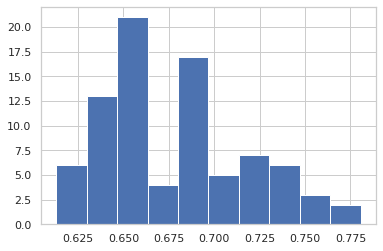

In [50]:
alpha = 0.05

#overall MASE
mean = summary_mase.to_numpy().flatten().mean()
print(f'\nOverall Benchmark Statistics for MASE')

#sample std
std = summary_mase.to_numpy().flatten().std(ddof=1)

n = summary_mase.to_numpy().flatten().shape[0]

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

#lower and upper 95% CI
print(f'mean: {mean:.2f} 95% CI ({lower:.2f}-{upper:.2f})')

#median
med = np.percentile(summary_mase.to_numpy().flatten(), 50)
lq = np.percentile(summary_mase.to_numpy().flatten(), 25)
uq = np.percentile(summary_mase.to_numpy().flatten(), 75)
print(f'median: {med:.2f}, IQR {uq - lq:.2f}')


#middle 90% of data lies between
fifth = np.percentile(summary_mase.to_numpy().flatten(), 5)
ninetyfifth = np.percentile(summary_mase.to_numpy().flatten(), 95)
print(f'middle 90%: {fifth:.2f} - {ninetyfifth:.2f}')

plt.hist(summary_mase.to_numpy().flatten());

## sMAPE

In [53]:
#Variability of sMAPE across regions in the South West of England
summary_smape = results_mean.filter(like="smape").filter(like="fbp-").filter(like='mean')

In [56]:
alpha = 0.05

#overall MASE
mean = summary_smape.to_numpy().flatten().mean()
print(f'\nOverall Benchmark Statistics for sMAPE')

#sample std
std = summary_smape.to_numpy().flatten().std(ddof=1)

n = summary_smape.to_numpy().flatten().shape[0]

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

#lower and upper 95% CI
print(f'mean: {mean:.2f} 95% CI ({lower:.2f}-{upper:.2f})')

#median
med = np.percentile(summary_smape.to_numpy().flatten(), 50)
lq = np.percentile(summary_smape.to_numpy().flatten(), 25)
uq = np.percentile(summary_smape.to_numpy().flatten(), 75)
print(f'median: {med:.2f}, IQR {uq - lq:.2f}')


#middle 90% of data lies between
fifth = np.percentile(summary_smape.to_numpy().flatten(), 5)
ninetyfifth = np.percentile(summary_smape.to_numpy().flatten(), 95)
print(f'middle 90%: {fifth:.2f} - {ninetyfifth:.2f}')


Overall Benchmark Statistics for sMAPE
mean: 4.57 95% CI (4.31-4.82)
median: 4.17, IQR 1.62
middle 90%: 2.55 - 6.67


In [58]:
#Variability of coverage 80 across regions in the South West of England
summary_coverage_80 = results_mean.filter(
    like="coverage_80").filter(like="fbp-").filter(like='mean')

In [60]:
alpha = 0.05

#overall cover 80
print(f'\nOverall Benchmark Statistics for 80% Coverage')
mean = summary_coverage_80.to_numpy().flatten().mean()

#sample std
std = summary_coverage_80.to_numpy().flatten().std(ddof=1)

n = summary_coverage_80.to_numpy().flatten().shape[0]

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

#lower and upper 95% CI
print(f'mean: {mean:.2f} 95% CI ({lower:.2f}-{upper:.2f})')

#median
med = np.percentile(summary_coverage_80.to_numpy().flatten(), 50)
lq = np.percentile(summary_coverage_80.to_numpy().flatten(), 25)
uq = np.percentile(summary_coverage_80.to_numpy().flatten(), 75)
print(f'median: {med:.2f}, IQR {uq - lq:.2f}')


#middle 90% of data lies between
fifth = np.percentile(summary_coverage_80.to_numpy().flatten(), 5)
ninetyfifth = np.percentile(summary_coverage_80.to_numpy().flatten(), 95)
print(f'middle 90%: {fifth:.2f} - {ninetyfifth:.2f}')


Overall Benchmark Statistics for 80% Coverage
mean: 0.84 95% CI (0.84-0.85)
median: 0.85, IQR 0.02
middle 90%: 0.80 - 0.87


In [61]:
#Variability of coverage 95 across regions in the South West of England
summary_coverage_95 = results_mean.filter(
    like="coverage_95").filter(like="fbp-").filter(like='mean')

In [63]:
alpha = 0.05

#overall cover 95
print(f'\nOverall Benchmark Statistics for 95% Coverage')
mean = summary_coverage_95.to_numpy().flatten().mean()

#sample std
std = summary_coverage_95.to_numpy().flatten().std(ddof=1)

n = summary_coverage_95.to_numpy().flatten().shape[0]

#Confidence interval calculation
se = std / np.sqrt(n)
z = np.abs(t.ppf(alpha / 2, n - 1))
hw = z * se
lower = mean - hw
upper = mean + hw

#lower and upper 95% CI
print(f'mean: {mean:.2f} 95% CI ({lower:.2f}-{upper:.2f})')

#median
med = np.percentile(summary_coverage_95.to_numpy().flatten(), 50)
lq = np.percentile(summary_coverage_95.to_numpy().flatten(), 25)
uq = np.percentile(summary_coverage_95.to_numpy().flatten(), 75)
print(f'median: {med:.2f}, IQR {uq - lq:.2f}')


#middle 90% of data lies between
fifth = np.percentile(summary_coverage_95.to_numpy().flatten(), 5)
ninetyfifth = np.percentile(summary_coverage_95.to_numpy().flatten(), 95)
print(f'middle 90%: {fifth:.2f} - {ninetyfifth:.2f}')


Overall Benchmark Statistics for 95% Coverage
mean: 0.96 95% CI (0.96-0.97)
median: 0.96, IQR 0.01
middle 90%: 0.95 - 0.97


# Overall accuracy summary by region (not in paper)

In [34]:
region_means = results_mean.filter(like="mase").filter(like='mean').mean().sort_index()
region_std = results_mean.filter(like="mase").filter(like='std').mean().sort_index()
region_95_mean = results_mean.filter(like="coverage_95").filter(like='mean').mean().sort_index()
region_80_mean = results_mean.filter(like="coverage_80").filter(like='mean').mean().sort_index()
region_95_std = results_mean.filter(like="coverage_95").filter(like='std').mean().sort_index()
region_80_std = results_mean.filter(like="coverage_80").filter(like='std').mean().sort_index()

In [35]:
comparisons = list(region_means.index)
idx = [i.replace('_mase_mean', '') for i in comparisons]

In [36]:
df_regions = pd.DataFrame(region_means.to_numpy(), columns=['mean'])
df_regions['std'] = region_std.to_numpy()
df_regions['mean_80'] = region_80_mean.to_numpy()
df_regions['std_80'] = region_80_std.to_numpy()
df_regions['mean_95'] = region_95_mean.to_numpy()
df_regions['std_95'] = region_95_std.to_numpy()
df_regions['MASE'] = df_regions['mean'].map('{:,.2f}'.format) \
            + ' (' + df_regions['std'].map('{:,.2f}'.format) + ')'

df_regions['Coverage 80'] = df_regions['mean_80'].map('{:,.2f}'.format) \
            + ' (' + df_regions['std_80'].map('{:,.2f}'.format) + ')'

df_regions['Coverage 95'] = df_regions['mean_95'].map('{:,.2f}'.format) \
            + ' (' + df_regions['std_95'].map('{:,.2f}'.format) + ')'

df_regions.index = idx
df_regions = df_regions.drop(['mean', 'std', 'mean_80', 'std_80', 
                              'mean_95', 'std_95'], axis=1)

idx = df_regions.index
labels = [s.replace('-fbp-arima', '') for s in idx]
df_regions.index = labels
df_regions

,MASE,Coverage 80,Coverage 95
BNSSG,0.74 (0.15),0.84 (0.09),0.96 (0.04)
Cornwall,0.66 (0.12),0.85 (0.09),0.97 (0.04)
Devon,0.64 (0.14),0.86 (0.08),0.97 (0.03)
Dorset,0.64 (0.09),0.87 (0.06),0.97 (0.03)
Gloucestershire,0.69 (0.08),0.83 (0.06),0.96 (0.04)
Somerset,0.72 (0.15),0.80 (0.10),0.95 (0.05)
Trust,0.70 (0.19),0.86 (0.10),0.97 (0.04)
Wiltshire,0.66 (0.11),0.85 (0.07),0.96 (0.03)
